In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
import csv

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso,ElasticNet,RidgeCV,LassoCV,ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [149]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = "/content/drive/My Drive/Datasets/EPL.csv"
path2 = "/content/drive/My Drive/Datasets/EPL 2017.csv"
data = pd.read_csv(path)
data2 = pd.read_csv(path2)

In [0]:
teamList = ['Arsenal', 'Bournemouth', 'Burnley', 'Chelsea', 'Crystal Palace', 'Everton', 'Leicester', 'Liverpool', 'Man City', 'Man United', 'Southampton', 'Stoke', 'Swansea', 'Tottenham', 'Watford', 'West Brom', 'West Ham']
def win(row):
    if (row["FTR"] == "A"):
        return row["AwayTeam"]
    elif (row["FTR"] == "H"):
        return row["HomeTeam"]
    elif (row["FTR"] == "D"):
        return "None"
    

def lose(row):
    if (row["FTR"] == "A"):
        return row["HomeTeam"]
    elif (row["FTR"]  == "H"):
        return row["AwayTeam"]
    elif (row["FTR"]  == "D"):
        return "None"

data["Winner"] = data.apply(win,axis=1)
data["Loser"] = data.apply(lose,axis=1)

data2["Winner"] = data2.apply(win,axis=1)
data2["Loser"] = data2.apply(lose,axis=1)


In [0]:
def TeamData(teamName):
    annual_data = data
    #num goals scored in wins and losses 
    gamesHome = annual_data[annual_data["HomeTeam"] == teamName]
    totalGoalsScored = gamesHome["FTHG"].sum()
    gamesAway = annual_data[annual_data["AwayTeam"] == teamName]
    totalGames = gamesHome.append(gamesAway)
    numGames = len(totalGames.index)
    #total goals scored
    totalGoalsScored += gamesAway["FTAG"].sum()
    #total goals allowed
    totalGoalsAllowed = gamesHome["FTAG"].sum()
    totalGoalsAllowed += gamesAway["FTHG"].sum()
    #discipline: total red cards, total yellow cards
    totalYellowCards = gamesHome["HY"].sum()
    totalYellowCards += gamesAway["AY"].sum()
    totalRedCards = gamesHome["HR"].sum()
    totalRedCards += gamesHome["AY"].sum() 
    #total fouls 
    totalFouls = gamesHome["HF"].sum()
    totalFouls += gamesAway["AF"].sum()
    #total corners
    totalCorners = gamesHome["HC"].sum()
    totalCorners += gamesAway["AC"].sum()
    #shots per game (spg) = total shots / total games
    totalShots = gamesHome["HS"].sum()
    #avgshots per game
    totalShots += gamesAway["AS"].sum()
    if numGames != 0:
        spg = totalShots / numGames
    # avg shots allowed per game
    totalShotsAgainst = gamesHome["AS"].sum()
    totalShotsAgainst += gamesAway["HS"].sum()
    if numGames != 0:
        sag = totalShotsAgainst / numGames
    #Games Won percentage = Games Won / (Games won + Games Lost)
    gamesWon = annual_data[annual_data["Winner"] == teamName]
    gamesLost = annual_data[annual_data["Loser"] == teamName]
    numGamesWon = len(gamesWon.index)
    numGamesLost = len(gamesLost.index)
    if numGames != 0:
        gamesWonPercentage = numGamesWon / numGames
     #Defense stats
        #Goalie Saves = Shots on Goal - Goal Scored
    #totalShotsonGoal = tsog
    tsog  = gamesHome["HST"].sum()
    tsog += gamesAway["AST"].sum()
    goalieSaves = tsog - totalGoalsAllowed
       #Saves Percentage = Goalie Saves / Shots on Goal
    if tsog != 0:
        savesPercentage = goalieSaves / tsog
        #Saves Ratio = shots on Goal / Goalie Saves
    if goalieSaves != 0:
        savesRatio = tsog / goalieSaves
    
    #offense stats
        #Scoring Percentage = (Scoring Attempts - Goals Scored) / Scorring Attempts
    if totalShots != 0 :
        scoringPercentage = (totalShots - totalGoalsScored) / totalShots
        #Scoring Ratio = Shots on Goal / Goalie Saves
    if tsog != 0:
        scoringRatio = tsog / totalGoalsScored
        
    if numGames == 0: #if team not in dataset
        gamesWon = 0 
        gamesLost = 0
        totalGoalsScored = 0
        totalGoalsAllowed = 0
        totalYellowCards = 0
        totalRedCards = 0
        totalFouls = 0
        totalCorners = 0
        spg = 0
        sag = 0
        gamesWonPercentage = 0
        goalieSaves = 0 
        savesPercentage = 0
        savesRatio= 0
        scoringPercentage = 0 
        scoringRatio = 0 

    return[totalGoalsScored, totalGoalsAllowed, totalYellowCards, totalRedCards, scoringPercentage, totalFouls, totalCorners, spg, sag, gamesWonPercentage,goalieSaves, savesPercentage, savesRatio, scoringRatio]

##2019-20 Model Training


In [0]:
totalNumGames = 0 
totalNumGames += len(data.index)
numFeatures = len(TeamData("Arsenal"))# to find dimensionality
xTrain1 = np.zeros((totalNumGames, numFeatures))
yTrain1 = np.zeros((totalNumGames))


In [0]:
from collections import defaultdict
annualDictionary = defaultdict(list)
for team in teamList:
    team_vector = TeamData(team)
    annualDictionary[team] = team_vector

In [0]:
team_vectors = annualDictionary
annual = data
numGamesInYear = len(annual.index)
xTrainAnnual = np.zeros((numGamesInYear, numFeatures))
yTrainAnnual = np.zeros((numGamesInYear))
counter = 0

In [0]:
for index, row in annual.iterrows():
    h_team = row["HomeTeam"]
    h_vector = team_vectors[h_team]
    a_team = row["AwayTeam"]
    a_vector = team_vectors[a_team]
    diff = [a-b for a, b in zip(h_vector, a_vector)]
    if (counter % 2 == 0):
        if len(diff) != 0:
            xTrainAnnual[counter] = diff
        yTrainAnnual[counter] = 1
    else: 
        if len(diff)!=0:
            xTrainAnnual[counter] = [-p for p in diff]
        yTrainAnnual[counter] = 0
    counter += 1

In [157]:
indexCounter = 0 
xTrain1[indexCounter:numGamesInYear+indexCounter] = xTrainAnnual
yTrain1[indexCounter:numGamesInYear+indexCounter] = yTrainAnnual
indexCounter += numGamesInYear
print(xTrain1.shape)
print(yTrain1.shape)

(380, 14)
(380,)


## Previous Season data is added for accuracy


In [0]:
def TeamData2(teamName):
    annual_data = data2
    #num goals scored in wins and losses 
    gamesHome = annual_data[annual_data["HomeTeam"] == teamName]
    totalGoalsScored = gamesHome["FTHG"].sum()
    gamesAway = annual_data[annual_data["AwayTeam"] == teamName]
    totalGames = gamesHome.append(gamesAway)
    numGames = len(totalGames.index)
    #total goals scored
    totalGoalsScored += gamesAway["FTAG"].sum()
    #total goals allowed
    totalGoalsAllowed = gamesHome["FTAG"].sum()
    totalGoalsAllowed += gamesAway["FTHG"].sum()
    #discipline: total red cards, total yellow cards
    totalYellowCards = gamesHome["HY"].sum()
    totalYellowCards -= gamesAway["AY"].sum()
    totalRedCards = gamesHome["HR"].sum()
    totalRedCards -= gamesHome["AY"].sum() 
    #total fouls 
    totalFouls = gamesHome["HF"].sum()
    totalFouls += gamesAway["AF"].sum()
    #total corners
    totalCorners = gamesHome["HC"].sum()
    totalCorners += gamesAway["AC"].sum()
    #shots per game (spg) = total shots / total games
    totalShots = gamesHome["HS"].sum()
    #avgshots per game
    totalShots += gamesAway["AS"].sum()
    if numGames != 0:
        spg = totalShots / numGames
    # avg shots allowed per game
    totalShotsAgainst = gamesHome["AS"].sum()
    totalShotsAgainst += gamesAway["HS"].sum()
    if numGames != 0:
        sag = totalShotsAgainst / numGames
    #Games Won percentage = Games Won / (Games won + Games Lost)
    gamesWon = annual_data[annual_data["Winner"] == teamName]
    gamesLost = annual_data[annual_data["Loser"] == teamName]
    numGamesWon = len(gamesWon.index)
    numGamesLost = len(gamesLost.index)
    if numGames != 0:
        gamesWonPercentage = numGamesWon / numGames
     #Defense stats
        #Goalie Saves = Shots on Goal - Goal Scored
    #totalShotsonGoal = tsog
    tsog  = gamesHome["HST"].sum()
    tsog += gamesAway["AST"].sum()
    goalieSaves = tsog - totalGoalsAllowed
       #Saves Percentage = Goalie Saves / Shots on Goal
    if tsog != 0:
        savesPercentage = goalieSaves / tsog
        #Saves Ratio = shots on Goal / Goalie Saves
    if goalieSaves != 0:
        savesRatio = tsog / goalieSaves
    
    #offense stats
        #Scoring Percentage = (Scoring Attempts - Goals Scored) / Scorring Attempts
    if totalShots != 0 :
        scoringPercentage = (totalShots - totalGoalsScored) / totalShots
        #Scoring Ratio = Shots on Goal / Goalie Saves
    if tsog != 0:
        scoringRatio = tsog / totalGoalsScored
        
    if numGames == 0: #if team not in dataset
        gamesWon = 0 
        gamesLost = 0
        totalGoalsScored
        totalGoalsAllowed = 0
        totalYellowCards = 0
        totalRedCards = 0
        totalFouls = 0
        totalCorners = 0
        spg = 0
        sag = 0
        gamesWonPercentage = 0
        goalieSaves = 0 
        savesPercentage = 0
        savesRatio= 0
        scoringPercentage = 0 
        scoringRatio = 0 

    return[totalGoalsScored, totalGoalsAllowed, totalYellowCards, totalRedCards, totalFouls, totalCorners, spg, sag, gamesWonPercentage, goalieSaves, savesPercentage, savesRatio, scoringPercentage, scoringRatio]


## Model Training


In [0]:
totalNumGames = 0 
totalNumGames += len(data2.index)
numFeatures = len(TeamData2("Arsenal"))# to find dimensionality
xTrain2 = np.zeros((totalNumGames, numFeatures))
yTrain2 = np.zeros((totalNumGames))
from collections import defaultdict
annualDictionary = defaultdict(list)
for team in teamList:
    team_vector = TeamData2(team)
    annualDictionary[team] = team_vector
team_vectors = annualDictionary
annual = data2
numGamesInYear = len(annual.index)
xTrainAnnual = np.zeros((numGamesInYear, numFeatures))
yTrainAnnual = np.zeros((numGamesInYear))
counter = 0 
for index, row in annual.iterrows():
    h_team = row["HomeTeam"]
    h_vector = team_vectors[h_team]
    a_team = row["AwayTeam"]
    a_vector = team_vectors[a_team]
    diff = [a-b for a, b in zip(h_vector, a_vector)]
    if (counter % 2 == 0):
        if len(diff) != 0:
            xTrainAnnual[counter] = diff
        yTrainAnnual[counter] = 1
    else: 
        if len(diff)!=0:
            xTrainAnnual[counter] = [-p for p in diff]
        yTrainAnnual[counter] = 0
    counter += 1

indexCounter = 0 
xTrain2[indexCounter:numGamesInYear+indexCounter] = xTrainAnnual
yTrain2[indexCounter:numGamesInYear+indexCounter] = yTrainAnnual
indexCounter += numGamesInYear




In [160]:
xtrainfin = np.concatenate([xTrain2,xTrain1], axis=0)
ytrainfin = np.concatenate([yTrain2,yTrain1], axis=0)
xtrainfin.shape
ytrainfin.shape

(760,)

In [0]:
model1 = ExtraTreesClassifier()
model2 = RandomForestClassifier()

In [162]:
model1.fit(xtrainfin, ytrainfin)
print (model1.feature_importances_)

[0.07168555 0.07667825 0.07901543 0.06923645 0.07247229 0.06679691
 0.06617394 0.0741692  0.06877046 0.06743262 0.06308093 0.07554317
 0.07088895 0.07805586]


In [163]:
model2.fit(xtrainfin, ytrainfin)
print(model2.feature_importances_)

[0.06531069 0.06729393 0.07048333 0.06891563 0.07304908 0.07440244
 0.06682521 0.0770828  0.06584303 0.0674205  0.067243   0.07617074
 0.07144207 0.08851755]


#Feature Selection
### 1) Total yellow cards
### 2) Total red cards
### 3) Scoring percentage
### 4) SPG
### 5) Games won percentage


In [164]:
xTrain, X_test, yTrain, y_test = train_test_split(xtrainfin, ytrainfin)
xTrain.shape

(570, 14)

In [0]:
xTraindf = pd.DataFrame(xTrain, columns=['totalGoalsScored', 'totalGoalsAllowed', 'totalYellowCards', 'totalRedCards', 'totalFouls', 'totalCorners', 'spg', 'sag', 'gamesWonPercentage', 'goalieSaves', 'savesPercentage', 'savesRatio', 'scoringPercentage', 'scoringRatio'])
bylr = xTraindf.copy()
bylr['yTrain'] = yTrain

In [166]:
import pymc3 as pm
with pm.Model() as reg:
    pm.glm.GLM.from_formula('yTrain ~ totalGoalsScored + totalGoalsAllowed + totalYellowCards + totalRedCards + totalFouls + totalCorners + spg + sag + gamesWonPercentage + goalieSaves + savesPercentage + savesRatio + scoringPercentage + scoringRatio', bylr)
    trace = pm.sample(1000, cores=2, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, scoringRatio, scoringPercentage, savesRatio, savesPercentage, goalieSaves, gamesWonPercentage, sag, spg, totalCorners, totalFouls, totalRedCards, totalYellowCards, totalGoalsAllowed, totalGoalsScored, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:52<00:00, 76.92draws/s]


In [167]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

In [168]:
pm.traceplot(trace)

ImportError: ignored

In [170]:
pm.plot_posterior(trace)

ImportError: ignored

In [171]:
model_formula = 'Featuressum = '
for variable in trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'Featuressum =  0.51 * Intercept + 0.01 * totalGoalsScored + -0.00 * totalGoalsAllowed + 0.00 * totalYellowCards + 0.00 * totalRedCards + -0.00 * totalFouls + -0.00 * totalCorners + -0.00 * spg + -0.00 * sag + 0.01 * gamesWonPercentage + -0.00 * goalieSaves + -0.00 * savesPercentage + -0.30 * savesRatio + -0.14 * scoringPercentage + 0.11 * scoringRatio + -0.68 * sd_log__ + 0.50 * sd'

In [172]:
var_dict = {}
for variable in trace.varnames:
    var_dict[variable] = trace[variable]
var_weights = pd.DataFrame(var_dict)
var_means = var_weights.mean(axis=0)
var_means

Intercept             0.507165
totalGoalsScored      0.005929
totalGoalsAllowed    -0.004227
totalYellowCards      0.002717
totalRedCards         0.004840
totalFouls           -0.001030
totalCorners         -0.000377
spg                  -0.000965
sag                  -0.004320
gamesWonPercentage    0.007812
goalieSaves          -0.004173
savesPercentage      -0.000474
savesRatio           -0.298056
scoringPercentage    -0.135251
scoringRatio          0.112573
sd_log__             -0.684233
sd                    0.504705
dtype: float64

In [0]:
X_testt = pd.DataFrame(X_test, columns=['totalGoalsScored', 'totalGoalsAllowed', 'totalYellowCards', 'totalRedCards', 'totalFouls', 'totalCorners', 'spg', 'sag', 'gamesWonPercentage', 'goalieSaves', 'savesPercentage', 'savesRatio', 'scoringPercentage', 'scoringRatio'])
X_testt['Intercept'] = 1
names = X_testt.columns[1:]
X_testt = X_testt.loc[:, names]
var_means = var_means[names]

In [174]:
var_means


totalGoalsAllowed    -0.004227
totalYellowCards      0.002717
totalRedCards         0.004840
totalFouls           -0.001030
totalCorners         -0.000377
spg                  -0.000965
sag                  -0.004320
gamesWonPercentage    0.007812
goalieSaves          -0.004173
savesPercentage      -0.000474
savesRatio           -0.298056
scoringPercentage    -0.135251
scoringRatio          0.112573
Intercept             0.507165
dtype: float64

In [175]:
ppc = pm.sample_ppc(trace, model=reg, samples=1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 1000/1000 [00:01<00:00, 535.84it/s]


In [176]:
result = []
for i in ppc['y']:
    result.append(i.mean())
# ppc['y'][0].mean()
BLavgpredict = sum(result)/len(result)
print(BLavgpredict)

0.5102786187564393


In [0]:
def evaluate(xTrain, X_test, yTrain, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'AdaBoostRegressor', 'ElasticNet Regression',
                       'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = AdaBoostRegressor()
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(xTrain, yTrain)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.ix[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(yTrain)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.ix['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [178]:
results = evaluate(xTrain, X_test, yTrain, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: 
.ix is deprecated. Please us

In [0]:
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns[1:]
    X_test = X_test.ix[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.ix[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
        
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    print('Model  MAE: {:.4f}\nModel RMSE: {:.4f}'.format(mae, rmse))
    
    # Add the results to the comparison dataframe
    model_results.loc['Bayesian LR', :] = [mae, rmse]
    
    plt.figure(figsize=(12, 8))
    
    # Plot median absolute percentage error of all models
    ax = plt.subplot(1, 2, 1)
    model_results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'r', ax = ax)
    plt.title('Model Mean Absolute Error Comparison'); plt.ylabel('MAE'); 
    plt.tight_layout()
    
    # Plot root mean squared error of all models
    ax = plt.subplot(1, 2, 2)
    model_results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'b', ax = ax)
    plt.title('Model RMSE Comparison'); plt.ylabel('RMSE')
    
    return model_results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


Model  MAE: 0.5097
Model RMSE: 0.5465


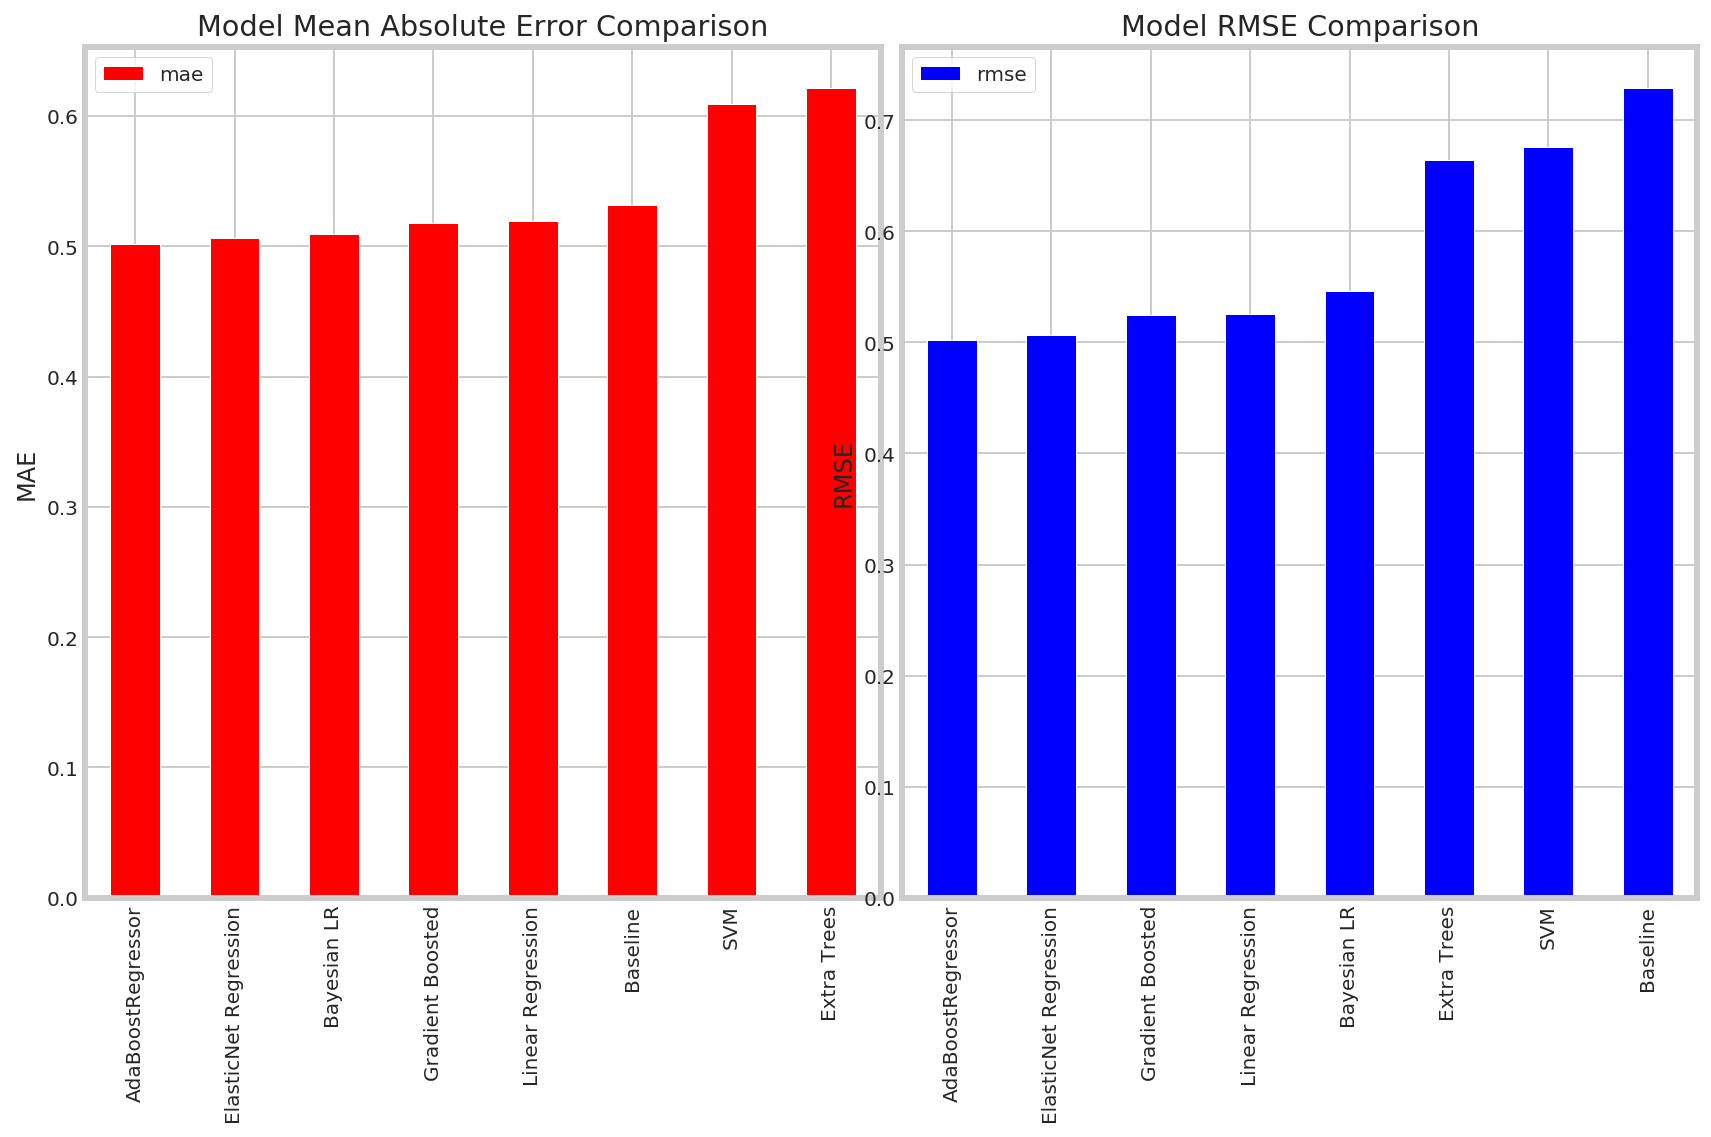

In [180]:
all_model_results = evaluate_trace(trace, xTrain, X_testt, yTrain, y_test, results)

#Results

In [181]:
results


,mae,rmse
Linear Regression,0.519218,0.525936
AdaBoostRegressor,0.501831,0.501995
ElasticNet Regression,0.506183,0.506845
Extra Trees,0.621512,0.664239
SVM,0.609541,0.676142
Gradient Boosted,0.518185,0.52433
Baseline,0.531579,0.729095
Bayesian LR,0.509679,0.546532


In [182]:
path3 = "/content/drive/My Drive/Datasets/Fixtures.csv"
data3 = pd.read_csv(path3)
test = data3
#test["Game ID"] = test["Game ID"].astype(int)
test.head()

,Match ID,Date,HomeTeam,AwayTeam
0,1,09/08/2019 20:00,Liverpool,Norwich
1,2,10/08/2019 12:30,West Ham,Man City
2,3,10/08/2019 15:00,Bournemouth,Sheffield Utd
3,4,10/08/2019 15:00,Burnley,Southampton
4,5,10/08/2019 15:00,Crystal Palace,Everton


#Predicting Home Game

In [0]:
def createGamePred(team1_vector, team2_vector, xTrain, yTrain):
    xTrain, X_test, yTrain, y_test = train_test_split(xtrainfin, ytrainfin)
    AB = AdaBoostRegressor()
    AB.fit(xTrain, yTrain)
    diff = np.array([a - b for a, b in zip(team1_vector, team2_vector)])
    predictions = AB.predict(diff.reshape(1,-1))
    return predictions

In [0]:
def formulatePredictions():
    probs = [[0 for x in range(2)] for x in range(len(test.index))]
    for index, row in test.iterrows():
        game_ID = row["Match ID"]
        team1_Name = row["HomeTeam"]
        team2_Name = row["AwayTeam"]
        team1_vector = TeamData(team1_Name)
        team2_vector = TeamData(team2_Name)
        prediction = createGamePred(team1_vector, team2_vector, xTrain, yTrain)
        probs[index][0] = game_ID
        probs[index][1] = prediction
    probs = pd.np.array(probs)
    return probs

#Predicting Away Games


In [0]:
#def createGamePred(team1_vector, team2_vector, xTrain, yTrain):
 #    xTrain, X_test, yTrain, y_test = train_test_split(xtrainfin, ytrainfin)
  #   AB = AdaBoostRegressor()
   #  AB.fit(xTrain, yTrain)
    # diff = np.array([a - b for a, b in zip(team1_vector, team2_vector)])
     #predictions = AB.predict(diff.reshape(1,-1))
     #return predictions

In [0]:
predictdf=pd.DataFrame(formulatePredictions(), columns=[["Match ID","Prediction"]])
pf1 = predictdf.drop(['Match ID'], axis = 1)
predictable = pd.concat([test, pf1], axis=1)
predictable.columns
ptdf = predictable.drop(predictable.index[-1])

#Taking out matches of Cardiff, Fulham and Huddersfield because of relegation

In [0]:
ptdf2 = ptdf[ptdf.HomeTeam.str.contains("Cardiff") == False]
ptdf3 = ptdf2[ptdf2.AwayTeam.str.contains("Fulham") == False]
ptdf4 = ptdf3[ptdf3.HomeTeam.str.contains("Huddersfield") == False]
ptdf5 = ptdf4[ptdf4.AwayTeam.str.contains("Huddersfield") == False]
ptdf6 = ptdf5[ptdf5.HomeTeam.str.contains("Cardiff") == False]
ptdf7 = ptdf6[ptdf6.AwayTeam.str.contains("Fulham") == False]

In [0]:
ptdf7.columns.values[4] = "HTwinPredict"
ptdf7["ATwinPredict"] = 1 - ptdf7.iloc[:,4]

In [0]:
def win(row):
    if (row["HTwinPredict"] > row["ATwinPredict"]):
        return row["HomeTeam"]
    elif (row["ATwinPredict"] > row["HTwinPredict"]):
        return row["AwayTeam"]
    elif (row["ATwinPredict"] == row["HTwinPredict"]):
        return "DRAW"
    

def lose(row):
    if (row["HTwinPredict"] < row["ATwinPredict"]):
        return row["HomeTeam"]
    elif (row["ATwinPredict"] < row["HTwinPredict"]):
        return row["AwayTeam"]
    elif (row["ATwinPredict"] == row["HTwinPredict"]):
        return "DRAW"

ptdf7["Winner"] = ptdf7.apply(win, axis=1) 
ptdf7["Loser"] = ptdf7.apply(lose, axis=1)

In [196]:
ptdf7["Winner"].value_counts()

Everton           23
Newcastle         22
Brighton          22
Man City          21
Sheffield Utd     21
Watford           20
Southampton       20
Arsenal           20
Leicester         20
Burnley           19
Aston Villa       18
Liverpool         18
Norwich           18
Chelsea           17
Spurs             17
West Ham          17
Man Utd           16
Bournemouth       16
Crystal Palace    14
Wolves            11
DRAW               9
Name: Winner, dtype: int64

In [197]:
ptdf7["Loser"].value_counts()

Wolves            26
Crystal Palace    23
Man Utd           22
Bournemouth       20
West Ham          20
Liverpool         19
Chelsea           19
Norwich           18
Arsenal           18
Watford           18
Leicester         18
Spurs             18
Southampton       18
Burnley           18
Aston Villa       17
Man City          17
Sheffield Utd     16
Everton           15
Brighton          15
Newcastle         15
DRAW               9
Name: Loser, dtype: int64